In [92]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pystan
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import scipy as sp
import matplotlib.pyplot as plt

az.style.use('arviz-darkgrid')

# Medium

## 12M1

In [115]:
frogs = pd.read_csv('/Users/benjaminwee/Documents/courses/resources/Rethinking/Data/reedfrogs.csv',
                    sep=",")

# Create list of clusters (stan doesn't take zero as a cluster id)
tanks = np.arange(frogs.shape[0])+1

# Create dummies
frogs_df = pd.get_dummies(frogs, columns = ['pred', 'size'])\
             .drop(['pred_no', 'size_small'], axis = 1)\
             .rename(columns = {'size_big' : 'tsize',
                                'pred_pred' : 'pred'})\

# Create interactive variable
frogs_df['size_pred'] = frogs_df['tsize'] * frogs_df['pred']

frogs_df.head()

,density,surv,propsurv,pred,tsize,size_pred
0,10,9,0.9,0,1,0
1,10,10,1.0,0,1,0
2,10,7,0.7,0,1,0
3,10,10,1.0,0,1,0
4,10,9,0.9,0,0,0


In [52]:
frogs_df['pred'].drop_duplicates()

0    0
8    1
Name: pred, dtype: uint8

In [116]:
m_12_1_clust = '''
data {
    int N; // Number of rows
    int n_tanks; // Number of clusters
    int density[N]; // Number in each tank
    int surv[N]; // Number survived
    int tank_id[N]; // Cluster identifier
}
parameters {
    real alpha;
    real<lower=0> sigma;
    vector[n_tanks] a_tank; // Fixed effects
}
model {
    vector[N] p; // parameter p
    
    // Prior Model 
    target += normal_lpdf(alpha | 0, 1);
    target += cauchy_lpdf(sigma | 0, 1);
    target += normal_lpdf(a_tank | alpha, sigma);
    
    // Observational Model
    for(n in 1:N) p[n] = inv_logit(a_tank[tank_id[n]]); // Inverse logit of Linear model (log-odds)
    target += binomial_lpmf(surv|density, p); // Log-likelihood
}
generated quantities {
    vector[N] log_lik;
    {
    vector[N] p;
    for (n in 1:N){
    p[n] = inv_logit(a_tank[tank_id[n]]);
    log_lik[n] = binomial_lpmf(surv[n]|density[n], p[n]);
    }
    }
}
'''

m_12_1_pred = '''
data {
    int N; // Number of rows
    int n_tanks; // Number of clusters
    int density[N]; // Number in each tank
    int surv[N]; // Number survived
    int tank_id[N]; // Cluster identifier
    int pred[N]; // Pred covariate
}
parameters {
    real alpha;
    real<lower=0> sigma;
    real bpred;
    vector[n_tanks] a_tank; // Fixed effects
}
model {
    vector[N] p; // parameter p
    
    // Prior Model 
    target += normal_lpdf(alpha | 0, 1);
    target += cauchy_lpdf(sigma | 0, 1);
    target += normal_lpdf(a_tank | alpha, sigma);
    target += normal_lpdf(bpred | 0, 1);
    
    // Observational Model
    for(n in 1:N) p[n] = inv_logit(a_tank[tank_id[n]] + bpred * pred[n]); // Inverse logit of Linear model (log-odds)
    target += binomial_lpmf(surv|density, p); // Log-likelihood
}
generated quantities {
    vector[N] log_lik;
    {
    vector[N] p;
    for (n in 1:N){
    p[n] = inv_logit(a_tank[tank_id[n]]+ bpred * pred[n]);
    log_lik[n] = binomial_lpmf(surv[n]|density[n], p[n]);
    }
    }
}
'''

m_12_1_size = '''
data {
    int N; // Number of rows
    int n_tanks; // Number of clusters
    int density[N]; // Number in each tank
    int surv[N]; // Number survived
    int tank_id[N]; // Cluster identifier
    int tsize[N]; //size covariate
}
parameters {
    real alpha;
    real<lower=0> sigma;
    vector[n_tanks] a_tank; // Fixed effects
    real bsize;
}
model {
    vector[N] p; // parameter p
    
    // Prior Model 
    target += normal_lpdf(alpha | 0, 1);
    target += cauchy_lpdf(sigma | 0, 1);
    target += normal_lpdf(a_tank | alpha, sigma);
    target += normal_lpdf(bsize| 0, 1);
    
    // Observational Model
    for(n in 1:N) p[n] = inv_logit(a_tank[tank_id[n]] + bsize * tsize[n]); // Inverse logit of Linear model (log-odds)
    target += binomial_lpmf(surv|density, p); // Log-likelihood
}
generated quantities {
    vector[N] log_lik;
    {
    vector[N] p;
    for (n in 1:N){
    p[n] = inv_logit(a_tank[tank_id[n]]+ bsize * tsize[n]);
    log_lik[n] = binomial_lpmf(surv[n]|density[n], p[n]);
    }
    }
}
'''

m_12_1_both = '''
data {
    int N; // Number of rows
    int n_tanks; // Number of clusters
    int density[N]; // Number in each tank
    int surv[N]; // Number survived
    int tank_id[N]; // Cluster identifier
    int pred[N]; // pred covariate
    int tsize[N]; // size covariate
}
parameters {
    real alpha;
    real<lower=0> sigma;
    vector[n_tanks] a_tank; // Fixed effects
    real bsize;
    real bpred;
    
}
model {
    vector[N] p; // parameter p
    
    // Prior Model 
    target += normal_lpdf(alpha | 0, 1);
    target += cauchy_lpdf(sigma | 0, 1);
    target += normal_lpdf(a_tank | alpha, sigma);
    target += normal_lpdf(bsize| 0, 1);
    target += normal_lpdf(bpred| 0, 1);
    
    // Observational Model
    for(n in 1:N) p[n] = inv_logit(a_tank[tank_id[n]] + bpred * pred[n] + bsize * tsize[n]); // Inverse logit of Linear model (log-odds)
    target += binomial_lpmf(surv|density, p); // Log-likelihood
}
generated quantities {
    vector[N] log_lik;
    {
    vector[N] p;
    for (n in 1:N){
    p[n] = inv_logit(a_tank[tank_id[n]] + bpred * pred[n] + bsize * tsize[n]);
    log_lik[n] = binomial_lpmf(surv[n]|density[n], p[n]);
    }
    }
}
'''

m_12_1_interact = '''
data {
    int N; // Number of rows
    int n_tanks; // Number of clusters
    int density[N]; // Number in each tank
    int surv[N]; // Number survived
    int tank_id[N]; // Cluster identifier
    int pred[N]; // pred covariate
    int tsize[N]; // size covariate
    int size_pred[N]; // interaction
}
parameters {
    real alpha;
    real<lower=0> sigma;
    vector[n_tanks] a_tank; // Fixed effects
    real bsize;
    real bpred;
    real binteract;
    
}
model {
    vector[N] p; // parameter p
    
    // Prior Model 
    target += normal_lpdf(alpha | 0, 1);
    target += cauchy_lpdf(sigma | 0, 1);
    target += normal_lpdf(a_tank | alpha, sigma);
    target += normal_lpdf(bsize| 0, 1);
    target += normal_lpdf(bpred| 0, 1);
    target += normal_lpdf(binteract| 0, 1);
    
    // Observational Model
    for(n in 1:N) p[n] = inv_logit(a_tank[tank_id[n]] + bpred * pred[n] + bsize * tsize[n] + binteract * size_pred[n]); // Inverse logit of Linear model (log-odds)
    target += binomial_lpmf(surv|density, p); // Log-likelihood
}
generated quantities {
    vector[N] log_lik;
    {
    vector[N] p;
    for (n in 1:N){
    p[n] = inv_logit(a_tank[tank_id[n]] + bpred * pred[n] + bsize * tsize[n] + binteract * size_pred[n]);
    log_lik[n] = binomial_lpmf(surv[n]|density[n], p[n]);
    }
    }
}
'''

In [104]:
clust = pystan.StanModel(model_code=m_12_1_clust)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ab13b23ba70b2ddb457545957ec7499b NOW.


In [105]:
size = pystan.StanModel(model_code=m_12_1_size)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee1357fd3ae2151fd8b34db7170010c9 NOW.


In [106]:
pred = pystan.StanModel(model_code=m_12_1_pred)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5c253d5da5d21d42494e1178195f5f7c NOW.


In [107]:
both = pystan.StanModel(model_code=m_12_1_both)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2041daf9bbfff65db67534fe4ce350e7 NOW.


In [117]:
interact = pystan.StanModel(model_code=m_12_1_interact)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dded980c56938b7b231551a40f617757 NOW.


In [118]:
frog_df = dict(N = len(frogs_df),
               n_tanks = max(tanks),
               tank_id = tanks,
               density = frogs_df['density'],
               surv = frogs_df['surv'],
               pred = frogs_df['pred'],
               tsize = frogs_df['tsize'],
               size_pred = frogs_df['size_pred'])

In [119]:
fit_m_12_1_clust = clust.sampling(data=frog_df)
fit_m_12_1_size = size.sampling(data=frog_df)
fit_m_12_1_pred = pred.sampling(data=frog_df)
fit_m_12_1_both = both.sampling(data=frog_df)
fit_m_12_1_interact = interact.sampling(data=frog_df)

In [120]:
samples_m_12_1_clust = az.from_pystan(posterior=fit_m_12_1_clust)
samples_m_12_1_size = az.from_pystan(posterior=fit_m_12_1_size)
samples_m_12_1_pred = az.from_pystan(posterior=fit_m_12_1_pred)
samples_m_12_1_both = az.from_pystan(posterior=fit_m_12_1_both)
samples_m_12_1_interact = az.from_pystan(posterior=fit_m_12_1_interact)

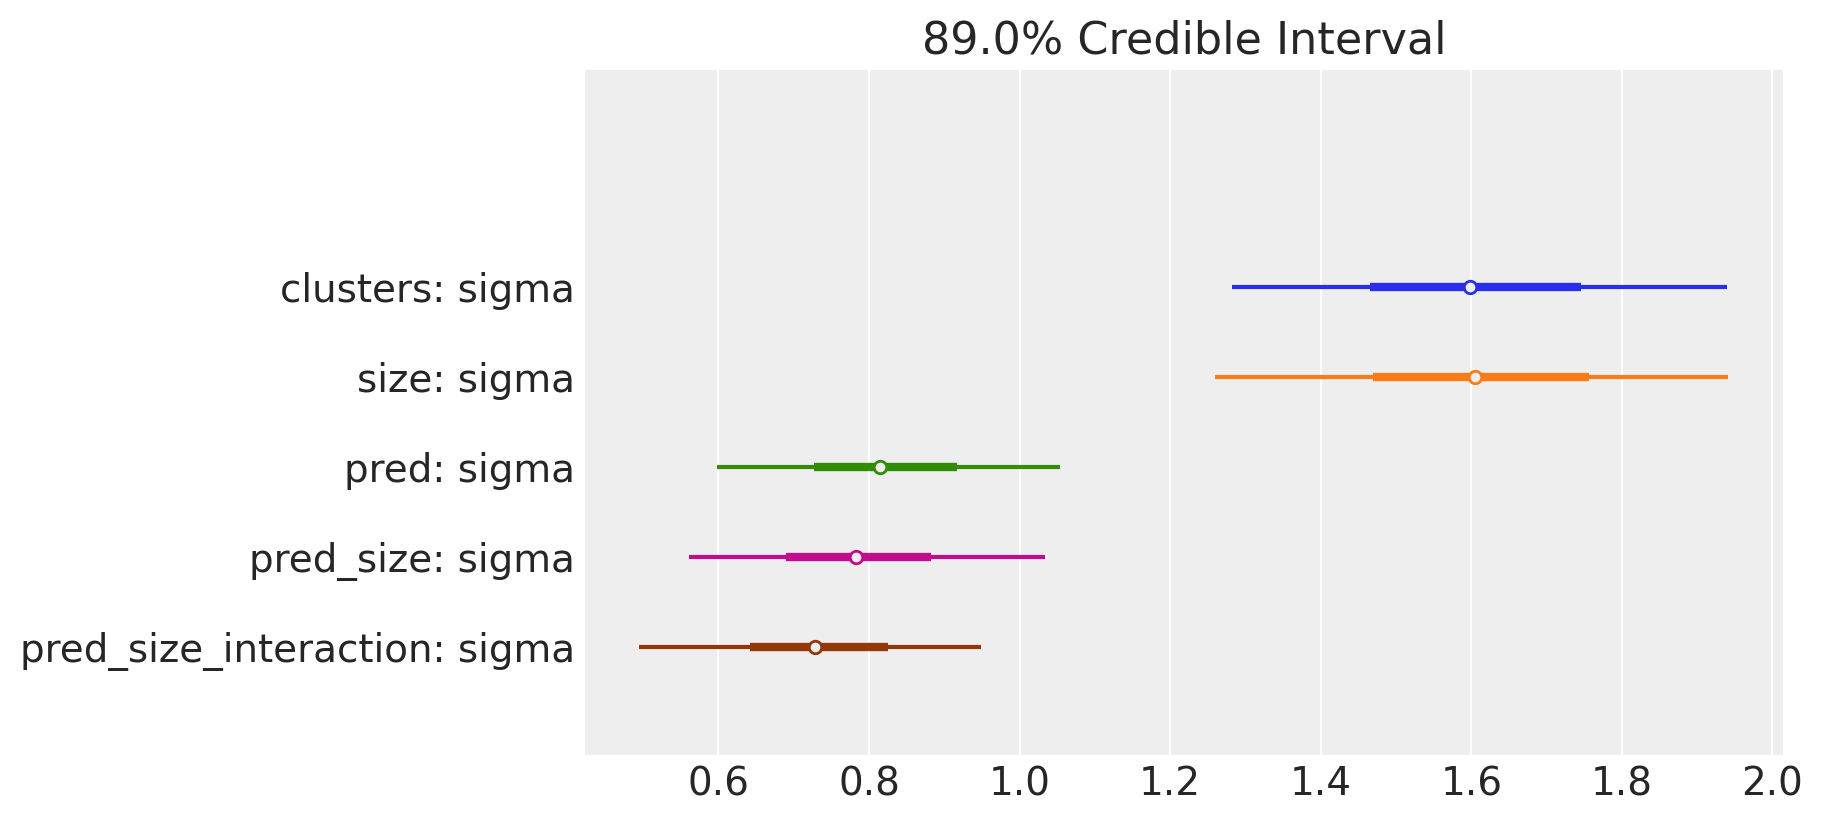

In [121]:
az.plot_forest([samples_m_12_1_clust, samples_m_12_1_size, samples_m_12_1_pred, samples_m_12_1_both, samples_m_12_1_interact], 
               model_names=["clusters", "size", "pred", "pred_size", "pred_size_interaction"], 
               var_names=["sigma"], credible_interval=.89, figsize=(9,4), combined=True);

More variation between clusters when no predictor variables. Adding variables absorb varation, so the variation between clusters become smaller. Size variable does not account for much variation so sigma is roughly the same as no predictor model.

## 12M2

In [122]:
ll_clust = az.from_pystan(fit_m_12_1_clust, log_likelihood="log_lik")
ll_size = az.from_pystan(fit_m_12_1_size, log_likelihood="log_lik")
ll_pred = az.from_pystan(fit_m_12_1_pred, log_likelihood="log_lik")
ll_both = az.from_pystan(fit_m_12_1_both, log_likelihood="log_lik")
ll_interact = az.from_pystan(fit_m_12_1_interact, log_likelihood="log_lik")

compare_dict = {'clusters' : ll_clust,
                'size' : ll_size,
                'pred' : ll_pred,
                'both' : ll_both,
                'interact': ll_interact}

az.compare(compare_dict, ic="waic")

/Users/benjaminwee/anaconda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
pred,0,199.295,19.2421,0,0.25022,8.48565,0,True,deviance
interact,1,200.173,19.2378,0.878638,0.227846,7.16351,3.32046,True,deviance
both,2,200.412,19.4415,1.11715,0.148664,7.20987,1.67595,True,deviance
clusters,3,200.739,21.1895,1.44377,0.187126,8.67104,5.42809,True,deviance
size,4,200.78,21.1479,1.48531,0.186144,9.32528,5.45727,True,deviance


Size only predictor has the weakest performance. Suggests that it's not an important variable. Although, creating an interactive variable in Stan (size[n] * pred[n]) instead of pandas pushed interact below both and clusters in terms of WAIC rank. Unsure why. Doing it in pandas matches PyMC3 results

In [123]:
az.plot_forest([trace_12_1_size, trace_12_1_both, trace_12_1_interact], 
               model_names=["size", "pred_size", "pred_size_interaction"], 
               var_names=["bsize"], credible_interval=.89, figsize=(9,4), combined=True);

NameError: name 'trace_12_1_size' is not defined